In [2]:
using PyCall
using PyPlot
using ForwardDiff, Flux
using LinearAlgebra
using Distributions
cmd = pyimport("cmdtools")

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/alex/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [4]:
N = 13

Q = cmd.systems.diffusion.DoubleWell(nx=N,beta=0.1).Q.todense()
K = exp(Q)

13×13 Array{Float64,2}:
 0.172451     0.390977     0.293061     …  8.65821e-9   3.06942e-10
 0.0758036    0.31735      0.356747        4.37093e-8   1.67867e-9
 0.0255383    0.160345     0.361291        2.95749e-7   1.24307e-8
 0.00723966   0.0607483    0.215296        2.30643e-6   1.07157e-7
 0.00173524   0.01825      0.0893244       1.83454e-5   9.52059e-7
 0.000346518  0.00438877   0.0275699    …  0.000134707  7.90521e-6
 5.72028e-5   0.000848848  0.00653459      0.000848848  5.72028e-5
 7.90521e-6   0.000134707  0.0012311       0.00438877   0.000346518
 9.52059e-7   1.83454e-5   0.000194505     0.01825      0.00173524
 1.07157e-7   2.30643e-6   2.78737e-5      0.0607483    0.00723966
 1.24307e-8   2.95749e-7   4.01553e-6   …  0.160345     0.0255383
 1.67867e-9   4.37093e-8   6.58001e-7      0.31735      0.0758036
 3.06942e-10  8.65821e-9   1.42647e-7      0.390977     0.172451

In [18]:
bnd = fill(NaN,size(K,1))
bnd[1:2] .= 0
bnd[end-1:end] .= 1

bndinds = findall(!isnan, bnd)
bnd

13-element Array{Float64,1}:
   0.0
   0.0
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   1.0
   1.0

In [19]:
function committor(K, b)
    A = copy(K)
    b = copy(b)
    for i in 1:length(b)
        if isnan(b[i])
            b[i] = 0
            A[i,i] -= 1
        else
            A[i,:].=0
            A[i,i]=1
        end
    end
    A\b
end

c = committor(K,bnd)

13-element Array{Float64,1}:
 0.0
 0.0
 0.23850564648072406
 0.3049943675485864
 0.3678245091452863
 0.43242726633319084
 0.5000000000000013
 0.567572733666812
 0.6321754908547159
 0.6950056324514149
 0.7614943535192767
 1.0
 1.0

In [20]:
sample(x) = rand(Categorical(K[x,:]))

random_data(nx, ny) = let xs = [rand(1:N) for i in 1:nx]
    [(x, [sample(x) for i in 1:ny]) for x in xs]
end

linear_data(ny) = [(x, [sample(x) for i in 1:ny]) for x in 1:N]

data = linear_data(100)

13-element Array{Tuple{Int64,Array{Int64,1}},1}:
 (1, [2, 2, 2, 1, 3, 2, 3, 3, 1, 2  …  3, 3, 4, 1, 3, 2, 2, 3, 2, 2])
 (2, [5, 2, 3, 6, 4, 3, 4, 4, 2, 3  …  3, 3, 4, 5, 2, 4, 4, 3, 5, 3])
 (3, [4, 4, 4, 5, 6, 4, 4, 6, 2, 3  …  5, 2, 1, 3, 2, 1, 4, 3, 4, 5])
 (4, [4, 6, 6, 4, 2, 2, 5, 3, 4, 4  …  4, 4, 4, 3, 4, 5, 4, 5, 6, 4])
 (5, [6, 4, 5, 6, 6, 6, 4, 5, 2, 5  …  6, 6, 3, 4, 4, 6, 5, 6, 5, 3])
 (6, [5, 5, 6, 6, 6, 6, 4, 6, 5, 7  …  4, 5, 5, 6, 7, 7, 4, 4, 7, 4])
 (7, [6, 6, 8, 8, 6, 6, 8, 5, 5, 8  …  8, 6, 8, 6, 8, 7, 5, 6, 6, 9])
 (8, [8, 9, 8, 9, 8, 8, 6, 7, 7, 5  …  8, 11, 5, 7, 9, 8, 6, 8, 6, 8])
 (9, [8, 7, 9, 10, 8, 9, 11, 8, 9, 11  …  9, 10, 9, 8, 10, 8, 11, 10, 9, 9])
 (10, [10, 11, 9, 9, 11, 11, 11, 10, 10, 11  …  10, 8, 9, 9, 12, 10, 8, 11, 10, 11])
 (11, [10, 11, 11, 11, 10, 12, 10, 11, 11, 11  …  9, 12, 12, 11, 11, 11, 11, 11, 10, 8])
 (12, [10, 9, 13, 12, 12, 11, 10, 11, 10, 12  …  13, 11, 11, 11, 11, 12, 11, 11, 11, 13])
 (13, [11, 11, 12, 10, 12, 12, 11, 10, 11, 9  …  

In [21]:
loss(c, x, ys) = abs(mean(c(y) for y in ys) - c(x))

loss_batch(c, batch) = mean(loss(c,d...) for d in batch)

loss_batch (generic function with 1 method)

In [24]:
struct VectorModel
    c
    bnd
    bndinds
end

function (m::VectorModel)(x) 
    if x in m.bndinds
        m.bnd[x]
    else
        m.c[x]
    end
end

Flux.trainable(m::VectorModel) = (m.c,)

model1 = VectorModel(rand(N), bnd, bndinds)
model1(5)

0.3693623198496667

In [28]:
struct NNModel
    nn
    bnd
    bndinds
end

function (m::NNModel)(x) 
    if x in m.bndinds
        m.bnd[x]
    else
        m.nn([x])[1] # we work with scalars, nn with arrays
    end
end

Flux.trainable(m::NNModel) = (m.nn, )

model2 = NNModel(Chain(Dense(1,10), Dense(10,1)), bnd, bndinds)
model2(5)

6.165518f0

In [31]:
model = model1
Flux.Optimise.train!(x->loss_batch(model, x),  Flux.params(model), [linear_data(10) for i in 1:10], ADAM())
model

VectorModel([0.3367358571926704, 0.10127873662385167, 0.26197775984015853, 0.5433656170355352, 0.37588485865798305, 0.5286565752568569, 0.21730838473298364, 0.207343963195601, 0.5549340454494, 0.21380982124884498, 0.05424532313425778, 0.5119558041232823, 0.17454545126352827], [0.0, 0.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 1.0, 1.0], [1, 2, 12, 13])

In [32]:
error(x::Vector) = norm(x - c) / sqrt(length(x))
error(f) = error([f(x) for x in 1:N])

error (generic function with 2 methods)

In [37]:
errors = []
losses = []

model = VectorModel(rand(N), bnd, bndinds)

opt = ADAM(0.1)

data_batch = [linear_data(100)] # 1 x sample 100 y sampes

local l, grad

@time for epoch in 1:1000 # run over same data 100 times

    for d in data_batch

        ps = Flux.params(model)
        l, pb = Flux.pullback(ps) do
            loss_batch(model, d)
        end
        grad = pb(1)
        Flux.Optimise.update!(opt, ps, grad)
        push!(errors, error(model))
        push!(losses, l)
    end
end



88.025574 seconds (270.43 M allocations: 10.636 GiB, 3.68% gc time)


13×2 Array{Float64,2}:
  0.0        0.0
  0.0        0.0
 -0.0857146  0.238506
  0.141526   0.304994
  0.278656   0.367825
  0.499171   0.432427
  0.606905   0.5
  0.751412   0.567573
  0.815331   0.632175
  0.948164   0.695006
  1.04454    0.761494
  1.0        1.0
  1.0        1.0

In [ ]:
chat = [model(x) for x in 1:N]

hcat(chat, c)

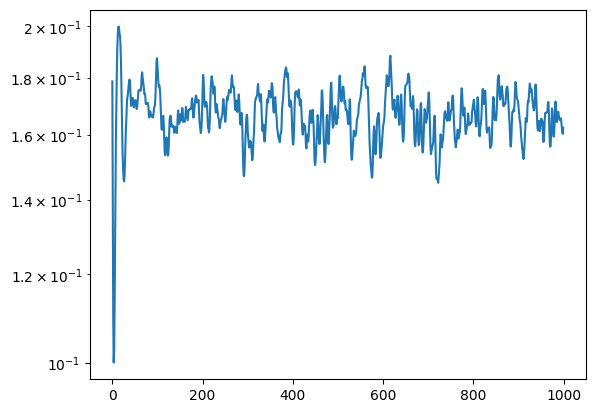

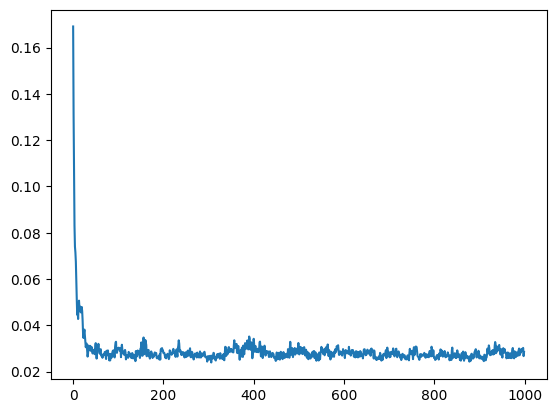

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1559ed370>

In [36]:
PyPlot.plot(errors)
PyPlot.yscale(:log)
figure()
plot(losses)
#yscale(:log)